In [2]:
# 以下是特別為了進行cross validation切割以及彙整所有CT資料使用，請視情況使用，無法直接run。
import glob, pandas as pd, os
import numpy as np
from pathlib import Path
from sklearn.model_selection import StratifiedKFold

In [3]:
#取得路徑下所有資料
count=0
data_getcwd = '/ssd2/ming/2024COVID' #base path
full_data_list = [] #儲存所有slice清單
full_path_list = [] #儲存所有CT資料夾清單

for i in ['negative', 'positive']:
        for path in Path(os.path.join(data_getcwd,'train/{}').format(i)).rglob('*.jpg'): #尋找所有*jpg檔案
                ct_name = str(path.parent).split('/')[-1]
                label = 0 if 'negative' in str(path) else 1
                token_key = ct_name+'_0' if 'negative' in str(path) else ct_name+'_1'
                full_data_list.append([str(path.parent), ct_name, str(path.name), label, 0, token_key])
                full_path_list.append([str(path.parent), label, 0, token_key])


full_data_list = pd.DataFrame(full_data_list, columns=['path', 'ct_name', 'slice_name','label', 'fold', 'token_key']).reset_index(drop=True) #重置index用於篩選location
full_path_list = pd.DataFrame(full_path_list, columns=['parent_path', 'label', 'fold', 'token_key']).drop_duplicates(subset='parent_path').reset_index(drop=True) #重置index用於篩選location

In [7]:
df = pd.DataFrame(full_path_list)

# Extracting 'negative' or 'positive' from each 'parent_path'
df['category'] = df['parent_path'].apply(lambda x: 'negative' if 'negative' in x else 'positive')

# Counting the occurrences of each category
category_counts = df['category'].value_counts()
category_counts

positive    703
negative    655
Name: category, dtype: int64

In [7]:
drop_count_t = 0
filter_num = 20
for path_ in full_path_list['parent_path']:
    i = len(os.listdir(path_))
    if i <filter_num:
        print(f"張數{i}", path_)

張數19 /ssd2/ming/2024COVID/train/negative/ct_scan_233
張數15 /ssd2/ming/2024COVID/train/negative/ct_scan_158
張數16 /ssd2/ming/2024COVID/train/negative/ct_scan_43
張數1 /ssd2/ming/2024COVID/train/positive/ct_scan_64
張數5 /ssd2/ming/2024COVID/train/positive/ct_scan_300
張數1 /ssd2/ming/2024COVID/train/positive/ct_scan_306
張數4 /ssd2/ming/2024COVID/train/positive/ct_scan_107


張數19 /ssd2/ming/2024COVID/train/negative/ct_scan_233
張數15 /ssd2/ming/2024COVID/train/negative/ct_scan_158
張數16 /ssd2/ming/2024COVID/train/negative/ct_scan_43
張數1 /ssd2/ming/2024COVID/train/positive/ct_scan_64
張數5 /ssd2/ming/2024COVID/train/positive/ct_scan_300
張數1 /ssd2/ming/2024COVID/train/positive/ct_scan_306
張數4 /ssd2/ming/2024COVID/train/positive/ct_scan_107


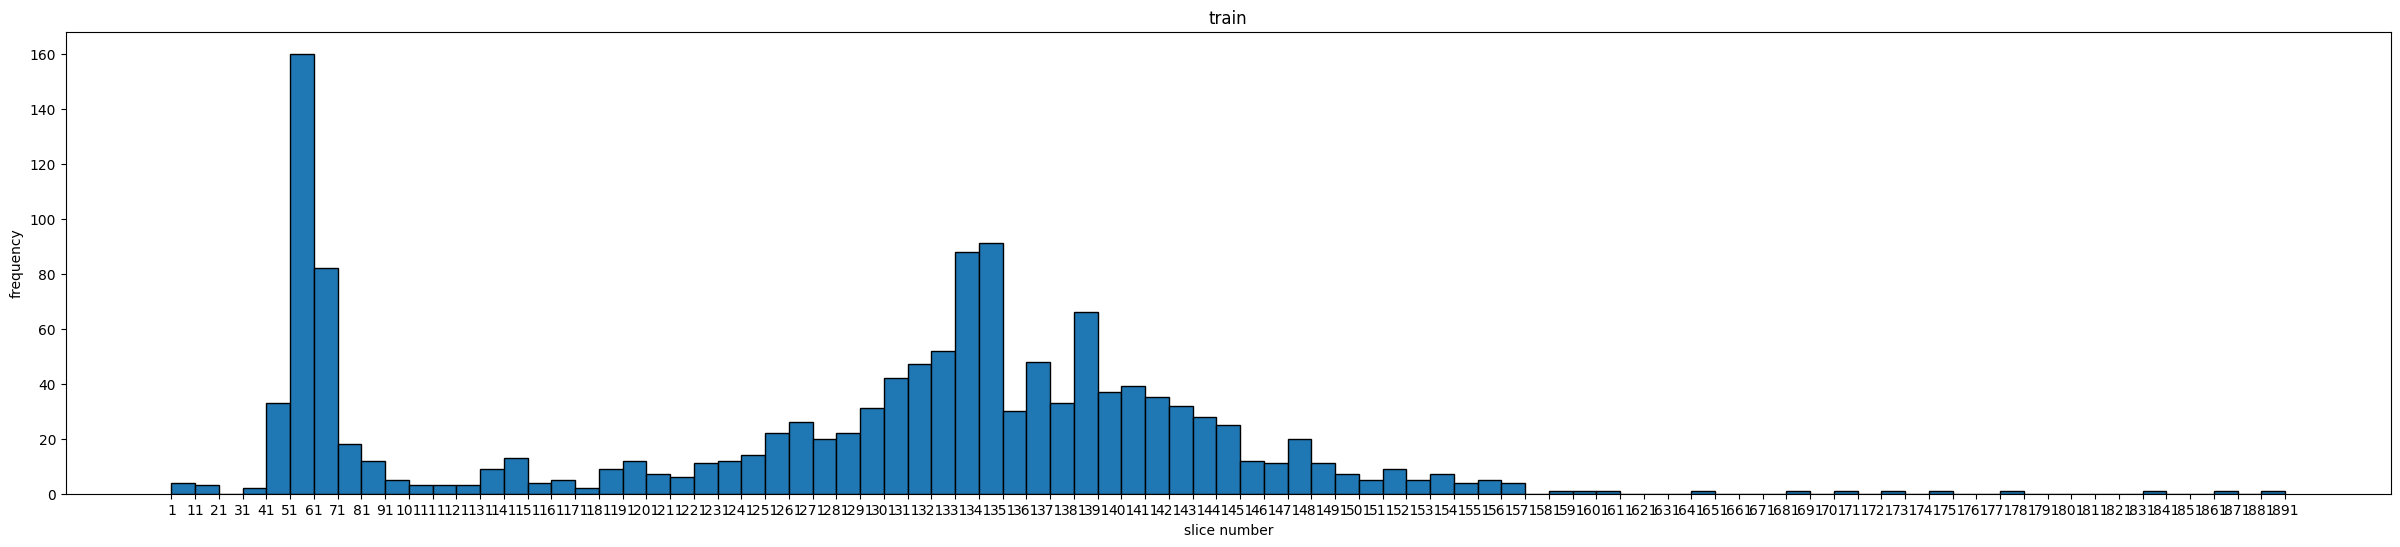

In [10]:
import os
import matplotlib.pyplot as plt

# 初始化张数列表
counts = []

# 遍历路径，计算每个目录中的文件数
for path_ in full_path_list['parent_path']:
    count = len(os.listdir(path_))
    counts.append(count)
    if count < filter_num:
        print(f"張數{count}", path_)

# 绘制直方图
bin_width = 10  # 或者20，根据需要调整
bins = range(min(counts), max(counts) + bin_width, bin_width)

# 绘制直方图
plt.figure(figsize=(30, 6))
plt.hist(counts, bins=bins, edgecolor='black')
plt.title('train')
plt.xlabel('slice number')
plt.ylabel('frequency')

# 设置X轴的标签
plt.xticks(bins)

plt.show()


In [6]:
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

In [7]:

for idx, (train, test) in enumerate(kfold.split(full_path_list['token_key'].values, full_path_list['label'].values)):#基於index設立fold number
    # print(test)
    full_path_list.loc[test, 'fold']=idx+1#將挑選出來的fold index用於篩選CT資料夾清單的index資料，並且將fold欄位全覆蓋為當前的fold number

In [8]:
from tqdm import tqdm
for i in tqdm(range (len(full_path_list))): #根據CT資料夾清單對所有Slice進行fold欄位覆蓋
    ct_name = full_path_list.loc[i].token_key#取得CT資料夾名字
    row_index = full_data_list['token_key']==ct_name #取得所有Slice清單中符合當前CT資料夾名字的index
    fold = full_path_list.loc[i].fold #取得CT資料夾清單的fold數字
    full_data_list.loc[row_index,'fold'] = fold #將挑選出來的slice清單的fold數字，全部替換成CT資料夾清單挑選出來的fold數字

  0%|          | 0/1358 [00:00<?, ?it/s]

100%|██████████| 1358/1358 [00:39<00:00, 34.65it/s]


In [9]:
drop_valid_df_list_ = full_data_list.drop_duplicates(subset='token_key')
all_train_list =[drop_valid_df_list_[drop_valid_df_list_['label']==1].path.values.tolist(),
                 drop_valid_df_list_[drop_valid_df_list_['label']==0].path.values.tolist()]

In [10]:
for i in [1,2,3,4]:
    temp = full_data_list[full_data_list['fold']==i]
    folder = temp['token_key'].drop_duplicates()
    label = temp.drop_duplicates(subset='token_key').label
    print("Fold-{} CT number: {} || Slice Sample: {} || CT covid: {}; CT non-covid: {}".format(i, len(folder),len(temp), sum(label), len(label)-sum(label)))
# full_data_list_save = full_data_list[['path', 'ct_name', 'slice_name','label', 'fold']]
full_data_list_save = full_data_list
full_data_list_save.to_csv('/ssd2/ming/2024COVID/chih_4_fold_covid_train_df.csv', index=False, encoding='utf-8-sig')
# full_data_list_save.to_csv('./Train_Valid_dataset/chih_4_fold_covid_train_df.csv', index=False, encoding='utf-8-sig')


Fold-1 CT number: 340 || Slice Sample: 99379 || CT covid: 176; CT non-covid: 164
Fold-2 CT number: 340 || Slice Sample: 95572 || CT covid: 176; CT non-covid: 164
Fold-3 CT number: 339 || Slice Sample: 98356 || CT covid: 175; CT non-covid: 164
Fold-4 CT number: 339 || Slice Sample: 92324 || CT covid: 176; CT non-covid: 163


In [8]:

count=0
data_getcwd = '/ssd2/ming/2024COVID' #base path
full_data_list = [] #儲存所有slice清單
full_path_list = [] #儲存所有CT資料夾清單

for i in ['negative', 'positive']:
        for path in Path(os.path.join(data_getcwd,'valid/{}').format(i)).rglob('*.jpg'): #尋找所有*jpg檔案
                ct_name = str(path.parent).split('/')[-1]
                label = 0 if 'negative' in str(path) else 1
                token_key = ct_name+'_0' if 'negative' in str(path) else ct_name+'_1'
                full_data_list.append([str(path.parent), ct_name, str(path.name), label, 0, token_key])
                full_path_list.append([str(path.parent), label, 0, token_key])


full_data_list = pd.DataFrame(full_data_list, columns=['path', 'ct_name', 'slice_name','label', 'fold', 'token_key']).reset_index(drop=True) #重置index用於篩選location
full_path_list = pd.DataFrame(full_path_list, columns=['parent_path', 'label', 'fold', 'token_key']).drop_duplicates(subset='parent_path').reset_index(drop=True) #重置index用於篩選location

In [9]:
df = pd.DataFrame(full_path_list)

# Extracting 'negative' or 'positive' from each 'parent_path'
df['category'] = df['parent_path'].apply(lambda x: 'negative' if 'negative' in x else 'positive')

# Counting the occurrences of each category
category_counts = df['category'].value_counts()
category_counts

positive    170
negative    156
Name: category, dtype: int64

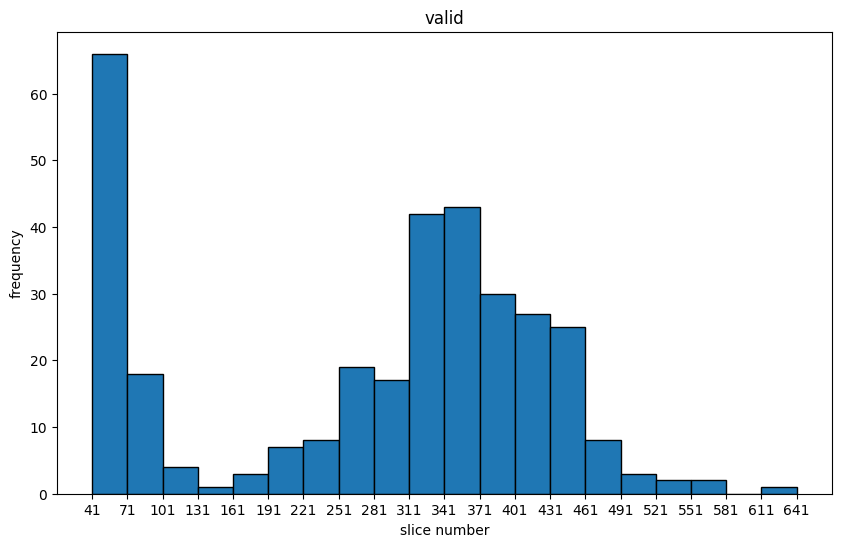

In [40]:
import os
import matplotlib.pyplot as plt

# 初始化张数列表
counts = []

# 遍历路径，计算每个目录中的文件数
for path_ in full_path_list['parent_path']:
    count = len(os.listdir(path_))
    counts.append(count)
    if count < filter_num:
        print(f"張數{count}", path_)

# 绘制直方图
bin_width = 30  # 或者20，根据需要调整
bins = range(min(counts), max(counts) + bin_width, bin_width)

# 绘制直方图
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=bins, edgecolor='black')
plt.title('valid')
plt.xlabel('slice number')
plt.ylabel('frequency')

# 设置X轴的标签
plt.xticks(bins)

plt.show()


In [14]:
for i in [0]:
    temp = full_data_list[full_data_list['fold']==i]
    folder = temp['token_key'].drop_duplicates()
    label = temp.drop_duplicates(subset='token_key').label
    print("Fold-{} CT number: {} || Slice Sample: {} || CT covid: {}; CT non-covid: {}".format(i, len(folder),len(temp), sum(label), len(label)-sum(label)))
# full_data_list_save = full_data_list[['path', 'ct_name', 'slice_name','label', 'fold']]
full_data_list_save = full_data_list
full_data_list_save.to_csv('/ssd2/ming/2024COVID/chih_4_fold_covid_valid_df.csv', index=False, encoding='utf-8-sig')
# full_data_list_save.to_csv('./Train_Valid_dataset/chih_4_fold_covid_train_df.csv', index=False, encoding='utf-8-sig')


Fold-0 CT number: 326 || Slice Sample: 90690 || CT covid: 170; CT non-covid: 156


In [15]:
full_data_list_save['fold']=5
full_data_list_save

,path,ct_name,slice_name,label,fold,token_key
0,/ssd2/ming/2024COVID/valid/negative/ct_scan_60,ct_scan_60,54.jpg,0,5,ct_scan_60_0
1,/ssd2/ming/2024COVID/valid/negative/ct_scan_60,ct_scan_60,13.jpg,0,5,ct_scan_60_0
2,/ssd2/ming/2024COVID/valid/negative/ct_scan_60,ct_scan_60,11.jpg,0,5,ct_scan_60_0
3,/ssd2/ming/2024COVID/valid/negative/ct_scan_60,ct_scan_60,12.jpg,0,5,ct_scan_60_0
4,/ssd2/ming/2024COVID/valid/negative/ct_scan_60,ct_scan_60,59.jpg,0,5,ct_scan_60_0
...,...,...,...,...,...,...
90685,/ssd2/ming/2024COVID/valid/positive/ct_scan_153,ct_scan_153,375.jpg,1,5,ct_scan_153_1
90686,/ssd2/ming/2024COVID/valid/positive/ct_scan_153,ct_scan_153,228.jpg,1,5,ct_scan_153_1
90687,/ssd2/ming/2024COVID/valid/positive/ct_scan_153,ct_scan_153,309.jpg,1,5,ct_scan_153_1
90688,/ssd2/ming/2024COVID/valid/positive/ct_scan_153,ct_scan_153,274.jpg,1,5,ct_scan_153_1


In [17]:
full_data_list_save.to_csv('/ssd2/ming/2024COVID/chih_4_fold_covid_valid_df.csv', index=False, encoding='utf-8-sig')

In [18]:
import pandas as pd
train=pd.read_csv('/ssd2/ming/2024COVID/chih_4_fold_covid_train_df.csv')
val=pd.read_csv('/ssd2/ming/2024COVID/chih_4_fold_covid_valid_df.csv')
full=pd.concat([train,val],axis=0)
full.to_csv('/ssd2/ming/2024COVID/chih_full_df.csv', index=False, encoding='utf-8-sig')
full['path']=full['path'].apply(lambda x: x.replace('train', 'train_pure_crop_challenge') if 'train' in x else x)
full['path']=full['path'].apply(lambda x: x.replace('valid', 'valid_pure_crop_challenge') if 'valid' in x else x)
full.to_csv('/ssd2/ming/2024COVID/chih_full_replaced_df.csv', index=False, encoding='utf-8-sig')